In [1]:
'''train a linear policy network on a grid world with random search'''
import os
import copy
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from utils import to_torch
from agent import Policy as Agent
from envs import GridWorld, ACTIONS

sns.set(style='white', context='talk', palette='colorblind')
np.random.seed(0)
torch.manual_seed(0)
# img_dir = '../figs'

In [2]:
def sample_weight_changes(agent, sigma=1):
    weight_change = {}
    for name, w in agent.named_parameters():
        weight_change[name] = torch.randn(w.data.size())*sigma
    return weight_change


def update_weights(agent, weight_change, factor):
    for name, w in agent.named_parameters():
        w.data += weight_change[name] * factor


def run(agent_):
    env.reset()
    locs = [env.get_agent_loc()]
    cumulative_reward, step = 0, 0
    while step < max_steps:
        # get current state
        s_t = to_torch(env.get_agent_loc().reshape(1, -1))
        # take an action
        a_t, prob_a_t = agent_.choose_action(s_t)
        # get a reward, make env transition
        r_t = env.step(a_t)
        # updates
        cumulative_reward += r_t * gamma ** step
        step += 1
        locs.append(env.get_agent_loc())
        # termination condition
        if env.is_terminal():
            break
    return cumulative_reward, step, locs

In [3]:
# define env and agent
env = GridWorld(has_bomb=True)
state_dim = env.height * env.width
n_actions = len(ACTIONS)
agent = Agent(dim_input=state_dim, dim_output=n_actions)

# training params
max_steps = 100
gamma = .9
alpha = 0.03
n_epochs = 1000
n_trials = 5

In [4]:
log_return = np.zeros((n_epochs, 2, n_trials))
log_steps = np.zeros((n_epochs, 2, n_trials))

for epoch_id in range(n_epochs):
    # propose a mutation vector
    weight_change = sample_weight_changes(agent)
    # create agent +/-
    agent_l = copy.deepcopy(agent)
    update_weights(agent_l, weight_change, factor=-1)
    agent_r = copy.deepcopy(agent)
    update_weights(agent_r, weight_change, factor=1)
    agent_lr = [agent_l, agent_r]
    for j, agent_j in enumerate(agent_lr):
        # run the agent for several trials
        for i in range(n_trials):
            cumulative_reward, step, locs = run(agent_j)
            log_return[epoch_id, j, i] = cumulative_reward
            log_steps[epoch_id, j, i] = step
    # update weights
    mean_return_lr = np.mean(log_return[epoch_id], axis=1)
    step_size = (mean_return_lr[1] - mean_return_lr[0]) * alpha
    update_weights(agent, weight_change, step_size)

    # log message
    return_ = np.mean(log_return[epoch_id])
    steps_ = np.mean(log_steps[epoch_id])
    if np.mod(epoch_id, 10) == 0:
        print('Epoch : %.3d | return: %.2f, steps: %.2f' % (
            epoch_id, return_, steps_))

Epoch : 000 | return: -0.25, steps: 61.20
Epoch : 010 | return: 0.07, steps: 78.40
Epoch : 020 | return: -0.95, steps: 70.20
Epoch : 030 | return: 0.00, steps: 100.00
Epoch : 040 | return: -0.94, steps: 75.50
Epoch : 050 | return: -0.60, steps: 61.40
Epoch : 060 | return: 1.07, steps: 62.50
Epoch : 070 | return: 0.65, steps: 67.10
Epoch : 080 | return: 0.14, steps: 83.90
Epoch : 090 | return: 0.55, steps: 65.80
Epoch : 100 | return: 0.00, steps: 100.00
Epoch : 110 | return: -0.17, steps: 91.80
Epoch : 120 | return: -0.58, steps: 80.00
Epoch : 130 | return: -0.00, steps: 99.50
Epoch : 140 | return: -0.37, steps: 84.10
Epoch : 150 | return: 0.07, steps: 88.00
Epoch : 160 | return: 0.75, steps: 78.10
Epoch : 170 | return: 0.61, steps: 62.40
Epoch : 180 | return: 0.10, steps: 77.40
Epoch : 190 | return: 0.22, steps: 77.90
Epoch : 200 | return: 0.10, steps: 81.70
Epoch : 210 | return: 0.25, steps: 90.80
Epoch : 220 | return: -0.79, steps: 67.50
Epoch : 230 | return: 0.42, steps: 61.00
Epoch

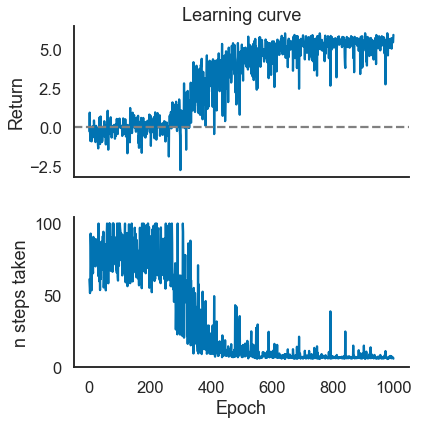

In [5]:
'''show learning curve: return, steps'''
lc_return = np.mean(np.mean(log_return, axis=-1), axis=-1)
lc_steps = np.mean(np.mean(log_steps, axis=-1), axis=-1)

f, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
axes[0].plot(lc_return)
axes[0].axhline(0, color='grey', linestyle='--')
axes[0].set_title('Learning curve')
axes[0].set_ylabel('Return')
axes[1].plot(lc_steps)
axes[1].set_title(' ')
axes[1].set_ylabel('n steps taken')
axes[1].set_xlabel('Epoch')
axes[1].set_ylim([0, None])
sns.despine()
f.tight_layout()
# f.savefig(os.path.join(img_dir, 'lc.png'), dpi=120)

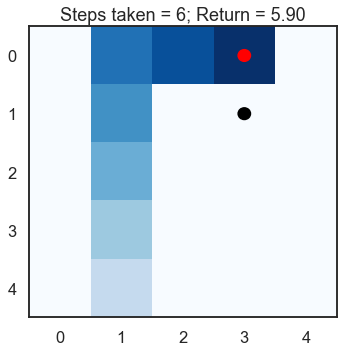

In [6]:
'''show a sample path'''
cumulative_reward, step, locs = run(agent)
color_intensity = np.linspace(.1, 1, step+1)
path = np.sum([color_intensity[t]*locs[t] for t in range(step+1)], axis=0)
path[path == 0] = -.2

f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title(f'Steps taken = {step}; Return = %.2f' % cumulative_reward)
ax.imshow(path, cmap='Blues', aspect='auto')
goal = Circle(env.gold_loc[::-1], radius=.1, color='red')
ax.add_patch(goal)
if env.has_bomb:
    bomb = Circle(env.bomb_loc[::-1], radius=.1, color='black')
    ax.add_patch(bomb)
f.tight_layout()
# f.savefig(os.path.join(img_dir, 'pg-path.png'), dpi=120)